# Formalia:
Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2022/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment.

If you fail to follow these simple instructions, it will negatively impact your grade!

Due date and time: The assignment is due on Tuesday November 1st, 2022 at 23:55. Hand in your IPython notebook file (with extension .ipynb) via http://peergrade.io/ (we won't be doing peergrading, but we'll still use http://peergrade.io/ for the handin.)

----

# Assignment 2: Network Science

_Course: 02805 - **Social Graphs and Interactions**_ <br>
_Course responsible: **Sune Lehmann Jørgensen**_ <br>
_DTU - **Technical University of Denmark**_  
_Due date - **01/11/2022**_ <br>
_Students - **Nikolaos Karageorgos, Ioannis Manganas, Georgios Panagiotopoulos**_

---

## Table of Contents:
- [__Part 0: Data__](#0.)

- [__Part 1: Basic Stats__](#1.)

- [__Part 2: Communities__](#2.)

- [__Part 3: Sentiment__](#3.)

---

# Introduction  

In Assignment 2 we will be working with Superheroes from the comics series of Marvel and DC. Each hero's data is the text from the corresponding Wikipedia page.  
In [Part 0](#0.) the functions and code used to extract the data for each superhero is presented. In [Part 1](#1.) the basic sstatistics and visualisations from the produced network are illustrated. [Part 2](#2.) explores the community structure of the network and finally, in [Part 3](#3.) sentiment analysis is implemented for the 'good' and 'bad' heroes.  

For this notebook, the questions will be shown as indented text, as follows:

> Question 

The answers are shown in the subsequent text cell , starting with __Answer__: 

Before starting, we install and import of the necessary libraries:

In [27]:
from io import BytesIO
import requests
import pandas as pd
from sqlalchemy import create_engine
import re
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import numpy as np
from tqdm.notebook import tqdm
import networkx as nx
import scipy.stats as st
import copy

The code of this notebook has been written and executed using the following versions of the librarier `scipy` and `networkx`:
* `scipy` version 1.9.1  
* `networkx` version 2.8.7

In [28]:
import scipy
print(f"scipy version: {scipy.__version__}")
print(f'networkx version: {nx.__version__}')

scipy version: 1.9.1
networkx version: 2.8.7


Our work has been made easier by the provision of the names and wikilinks of the characters for both the DC and Marvel Universes. This data is stored as `.csv` files at the github page of the course for the [Marvel](https://github.com/SocialComplexityLab/socialgraphs2022/blob/main/files/marvel.csv) and [DC](https://github.com/SocialComplexityLab/socialgraphs2022/blob/main/files/dc.csv) universes. We have created the text files and uploaded them to a [public github repository](https://github.com/gpanagioto/projects_socialgraphs22/tree/main/Assignment2/Txt_files).

<a id='0.'></a>
# Part 0: Data 

Our DC and Marvel superhero dataset after the proper extraction have been stored in a cloud PostgreSQL Database, easily and quickly accessible.

In [29]:
# Defining function for importing data from the cloud DB. The function returns two dataframes, one for each universe with two columns character_name, wiki_text
def DataImport(table_name):
  host="ec2-54-75-184-144.eu-west-1.compute.amazonaws.com"
  port="5432" 
  dbname="dab1kopm5t3l06"
  user="kpervzhazofybh" 
  password="0d1b5470c51c481880eed267865a8529bdc671f8cb90702d6dcb9e7c199d02ee"

  Engine   = create_engine('postgresql+psycopg2://{}:{}@{}:{}/{}'.format(user,password,host,port,dbname))

  # Connect to PostgreSQL server
  dbConnection = Engine.connect();

  # Read data from PostgreSQL database table and load into a DataFrame instance
  df = pd.read_sql("select * from {}".format(table_name), dbConnection)
  pd.set_option('display.expand_frame_repr', False)

  return df

The network has been saved as a `.gpickle` file and is available from the [repository](https://github.com/gpanagioto/projects_socialgraphs22/blob/main/Assignment2/SuperHeroesGraph.gpickle). In the following cell, this file is loaded and the DiGraph `G` contains the information for the superheroes network.

In [30]:
# Our Network has been stored as a pickle file in our GitHub Repository of this second assignment
mLink = 'https://github.com/gpanagioto/projects_socialgraphs22/blob/main/Assignment2/SuperHeroesGraph.gpickle?raw=true'
mfile = BytesIO(requests.get(mLink).content)
G = pickle.load(mfile)

#G_dir = pickle.load(open('/content/drive/MyDrive/DTU/02805 Social graphs and interactions/SuperHeroesGraph.gpickle', 'rb'))

Finally, the edge list for the generated network, _prior to removing any nodes_, has been stored in `.pickle` format in the [same public repository](https://github.com/gpanagioto/projects_socialgraphs22/blob/main/Assignment2/superheroes_edgelist.pickle). To recreate the network, the file `superheroes_edgelist.pickle` is loaded to a vriable using the `pickle` module. Then the graph is created by using `networkx`'s function [`from_edgelist`](https://networkx.org/documentation/stable/reference/generated/networkx.convert.from_edgelist.html), passing the optional argument `create_using=nx.DiGraph`.  
Moreover, the same edgelist is also stored as an `edgelist` file, named `superheroes.edgelist` using the `networkx`'s function [`write_edgelist`](https://networkx.org/documentation/stable/reference/readwrite/generated/networkx.readwrite.edgelist.write_edgelist.html#write-edgelist). This file is also available at the [github repository](https://github.com/gpanagioto/projects_socialgraphs22/blob/main/Assignment2/superheroes.edgelist).

<a id='1.'></a>
# Part 1: Basic Stats 

__Question__:
> * Write a short paragraph describing the network. The paragraph should contain the following information
>   * The number of nodes and links.
>   * The average, median, mode, minimum and maximum value of the network's in-degrees.  And of the out-degrees.

As a first step, we can find and remove edges from a character to itself. This achieved by the code in following cell:

In [31]:
i=0
duplicate_edges = []
for edge in G.edges():
    if edge[0]==edge[1]:
        duplicate_edges.append(edge)
        i+=1
print(f"Number of self-edges: {i}")

# Remove self referring edges 
G.remove_edges_from(duplicate_edges)

Number of self-edges: 193


__Answer__:  
The network that has been created from the Wikipages of each character, for both universes is stored in the graph `G`. It consists of $2538$ nodes and $29805$ edges, as shown in the following cell:

In [32]:
print('The number of nodes of the network are {}.\nThe number of edges of the network are {}.'.format(G.number_of_nodes(),G.number_of_edges()))

The number of nodes of the network are 2538.
The number of edges of the network are 29805.


To create the network, each character's wikipedia page was accessed using the provided wikilink. Afterwards, using the [wikipedia API](https://www.mediawiki.org/wiki/API:Tutorial), the contents of each page were downloaded and written to text files locally, as well as in a databse.  

The network was created by first adding each character as a node. Then the edges were added by reading the text for each character, finding the links with the help of regular expressions and adding an outgoing edge between the current character and the character that its wikipedia text links to.  

The result is a directed graph, since each edge has been creating pointing from the node that has a link on its wikipage towards the character that is linked. As a result, the in- and out- degrees are distinguished.  

In order to retrieve basic statistics for the network, the following function has been defined:

In [33]:
def Measures(Graph, TypeOfDegree, Data):    
    degree_type = 'Out-'
    if TypeOfDegree == 'In':
        values = list(dict(Graph.in_degree(Data)).values())
        degree_type = 'In-'
    else:
        values = list(dict(Graph.out_degree(Data)).values())
    
    print(f"{degree_type} degree statistics:\n")
    
    mean_ = np.mean(values)
    print("The average degree value is {}.".format(np.round(mean_,3)))
    median_ = np.median(values)
    print("The median is {}.".format(median_))
    mode_ = st.mode(values, keepdims=True)
    print("The mode is {}.".format(list(mode_)[0][0]))
    min_ = np.min(values)
    print("The minimum value is {}.".format(min_))
    max_ = np.max(values)
    print("The maximum value is {}.".format(max_))

    return mean_, median_, list(mode_)[0][0], min_, max_  

Using the function `Measures`, the following statistics can be calculated for the in- and out- degrees:

In [34]:
Data = list(G.nodes())
TypeOfDegree = 'In'
average, median, mode, min_, max_ = Measures(G, TypeOfDegree, Data)

In- degree statistics:

The average degree value is 11.743.
The median is 4.0.
The mode is 1.
The minimum value is 0.
The maximum value is 447.


In [35]:
Data = list(G.nodes())
TypeOfDegree = 'Out'
average, median, mode, min_, max_ = Measures(G, TypeOfDegree, Data)

Out- degree statistics:

The average degree value is 11.743.
The median is 7.0.
The mode is 0.
The minimum value is 0.
The maximum value is 111.


In [36]:
out_degrees = np.array([degree for node,degree in G.out_degree()])
in_degrees = np.array([degree for node, degree in G.in_degree()])

print(f"There are {len(out_degrees[out_degrees==0])} nodes with out-degree equal to 0.")
print(f"There are {len(in_degrees[in_degrees==0])} nodes with in-degree equal to 0.")

# Find if there are nodes with no incoming or outgoing edges at all
idx_out_zero = np.where(out_degrees==0)[0] # Nodes with 0 out-degree
in_degrees_at_zero_out = in_degrees[idx_out_zero] # In-degrees of nodes with 0 out-degrees
print(f"There are {len(in_degrees_at_zero_out[in_degrees_at_zero_out==0])} nodes with no incoming and no outgoing connection.")


There are 975 nodes with out-degree equal to 0.
There are 137 nodes with in-degree equal to 0.
There are 2 nodes with no incoming and no outgoing connection.


A network this large can create some difficulties with visualisation. Moreover, due to some unhandled corner cases, some characters might have ended up without text, and as a result, connections. They should be removed because they do not actively contribute to the analysis.  As in [Exercise 1, Week 5](https://github.com/SocialComplexityLab/socialgraphs2022/blob/main/lectures/Week5.ipynb), the largest weakly connected component is extracted. A directed graph is [defined as weakly connected](https://en.wikipedia.org/wiki/Connectivity_(graph_theory)) if all of ist nodes are connected when the graph is transformed from directed to undirected. To this end, `networkx`'s function [`weakly_connected_components`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.weakly_connected_components.html#networkx.algorithms.components.weakly_connected_components) is used:

In [37]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
print(f"The size of the largest connected component is {len(largest_cc)} nodes, out of a total of {G.number_of_nodes()} nodes.")

The size of the largest connected component is 2534 nodes, out of a total of 2538 nodes.


Even though the largest connected component is almost all the nodes of the graph, we will use it and keep working with that as the network.

In [38]:
Gcc = G.subgraph(largest_cc)

Since the network of the largest weakly connected component is almost the same in size with the original netowrk, the degree statistics are not repeated. From now on, the term network will refer to the `Gcc`, the subgraph of the largest connected component.

__Question__:
> * We also want the degree distributions and a plot of the network
>    * Create in- and out-going degree distributions as described in Lecture 5.
>    * Estimate the slope of the incoming degree distribtion as described in Lecture 5.
>    * Plot the network using the Force Atlas algorithm as described in Lecture 5.


__Answer__:  
The in- and out- degree distributions are created for the network and visualized as histogrmas, as well as scatterplots, that can give insights into the possible correlations between the degrees. Initially, the histogrmas are plotted:

In [39]:
# Calculate the in- and out - degree distribution for Gcc
in_degrees = np.array([degree for (node, degree) in Gcc.in_degree()])
out_degrees = np.array([degree for (node, degree) in Gcc.out_degree()])

# Calculate the bin size, histogram counts and edges for the in-degree distribution
v_in = np.arange(in_degrees.min(), in_degrees.max()+1, 1)
hist_in, edges_in = np.histogram(in_degrees, bins = v_in)

# Calculate the bin size, histogram counts and edges for the out-degree distribution
v_out = np.arange(out_degrees.min(), out_degrees.max()+1, 1)
hist_out, edges_out = np.histogram(out_degrees, bins = v_out)

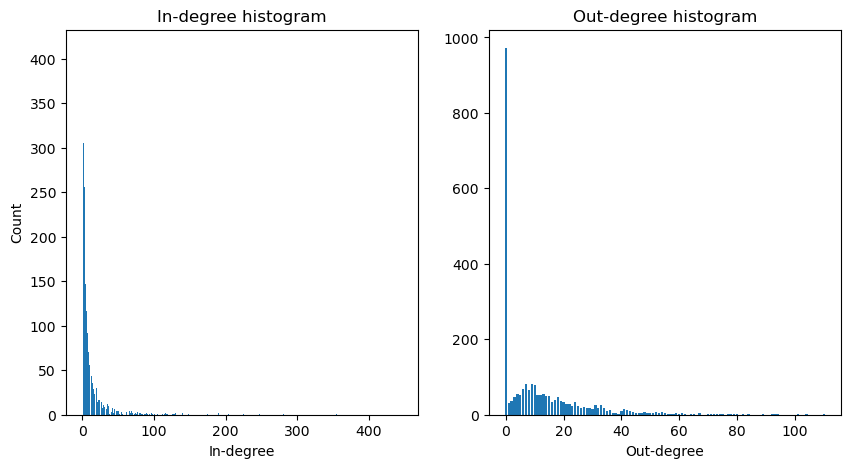

In [40]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.bar(edges_in[:-1], hist_in)
plt.xlabel('In-degree')
plt.ylabel('Count')
plt.title('In-degree histogram')

plt.subplot(1,2,2)
plt.bar(edges_out[:-1], hist_out)
plt.xlabel('Out-degree')
plt.title('Out-degree histogram')

plt.show()

Looking at the histograms of the in- and out- degree distribution, we can note that the out-degree distribution looks more like that of a random network. It follows a Poisson like distribution. The in-degree distribution is more in line with a real world network. A log-log plot, shown in the following, makes this easier to see.

In order to get more information regarding the network from the degree distributions, we can try to approximate the [exponent of the degree distribution](http://networksciencebook.com/chapter/4#power-laws). The exponent can give insigth in the [regime](http://networksciencebook.com/chapter/4#degree-exponent) our network is in.  

In order to estimate the slope of the incoming degree distribution, which is asked in the question, the package `powerlaw` will be used.

In [41]:
# ! pip install powerlaw
import powerlaw

In [42]:
gamma_in = powerlaw.Fit(in_degrees).alpha # Estimate the degree exponent for the in-degree distribution
print(f"The estimate of the degree exponent for the in-degree is {np.round(gamma_in,3)}")

The estimate of the degree exponent for the in-degree is 2.517


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


There are three [regimes](http://networksciencebook.com/chapter/4#degree-exponent) depending on the degree exponent $\gamma$ of a network:
- Anomalous Regime ($\gamma \leq 2$)
- Scale-Free Regime ($2 < \gamma < 3$)
- Random Network Regime ($\gamma > 3$)

Looking at the __in-degree__ distribution, the network is in the scale-free regime.

The in-degree distribution can be also plotted in a log-log scale:

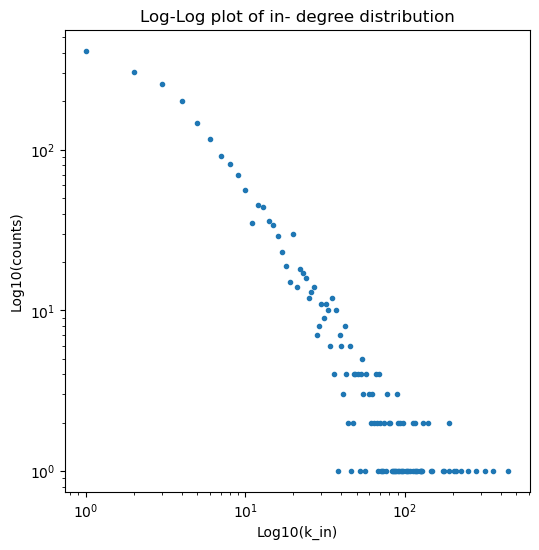

In [43]:
fig = plt.figure(figsize=(6,6))
plt.loglog(edges_in[:-1], hist_in, '.')
plt.title('Log-Log plot of in- degree distribution')
plt.xlabel('Log10(k_in)')
plt.ylabel('Log10(counts)')
plt.show()

As a note, the degree exponent for teh out-degree is calculated below:

In [44]:
gamma_out = powerlaw.Fit(out_degrees).alpha # Estimate the degree exponent for the ou-degree distribution
print(f"The estimate of the degree exponent for the out-degree is {np.round(gamma_out,3)}")

The estimate of the degree exponent for the out-degree is 4.352


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Looking at the out degree, the networ is in the random network regime. This also explains why the out-degree distribution's histogram looks more like a Poisson distribution.

Finally, the network is plotted using the [`ForceAtlas2`](https://github.com/bhargavchippada/forceatlas2) package. The color of each node will represent its univers, ie. DC or Marvel. It size will represent its degree. There are many nodes to visualize. We will work with the undirected version of the network graph, denoted as `G_undirected`.

In [45]:
# Import or install ForceAtlas2

# !pip install fa2
from fa2 import ForceAtlas2

In [46]:
# Create the undirected version of the graph Gcc
G_undirected = Gcc.to_undirected()

# Set the parameters to tune for the ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=30.0,
                        strongGravityMode=False,
                        gravity=220.0,

                        # Log
                        verbose=True
                        )

The color of each node will depend on its `universe` attribute, <span style="color:#4a91e8">DC</span> or <span style="color:#f56653">Marvel</span> .
 The following cell creates this node color vector:

In [47]:
# Create a dictionary to make it easier to check the type of the connections between characters.
# It will come in handy when checking if a character connects to the same or the other universe.
# Faster to use a dictionary than a pandas df 
character_affiliation_dict = {} 

# Nodes colors
color_a = '#4a91e8' # dc - Blue
color_b = '#f56653' # marvel - Red

color_map_nodes = []
for node in G_undirected.nodes(data=True):
    if node[1]['universe'].lower()=="dc":
        color_map_nodes.append(color_a)
    else:
        color_map_nodes.append(color_b)
    
    # Add the character and its affiliation to the dictionary
    character_affiliation_dict[node[0]] = node[1]['universe']

A color map can also be created for the edges. Each edge can be between  <span style="color:#a2cdfa">two DC characters</span>, <span style="color:#faafaa">two Marvel characters</span> or between two different universes, coloured black.

In [48]:
# Set the colors for the edges, depending on their type
col_dc_dc = '#a2cdfa'
col_marvel_marvel = '#faafaa'
col_marvel_dc = 'k' # black for visibility

color_map_edges = []

for char1, char2 in list(G_undirected.edges()):
    if character_affiliation_dict[char1] == character_affiliation_dict[char2]:
        if character_affiliation_dict[char1].lower()[0]=='m':
            color_map_edges.append(col_marvel_marvel)
        else:
            color_map_edges.append(col_dc_dc)
    else:
        color_map_edges.append(col_marvel_dc)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:15<00:00, 10.21it/s]


BarnesHut Approximation  took  28.75  seconds
Repulsion forces  took  160.41  seconds
Gravitational forces  took  0.60  seconds
Attraction forces  took  1.08  seconds
AdjustSpeedAndApplyForces step  took  2.82  seconds


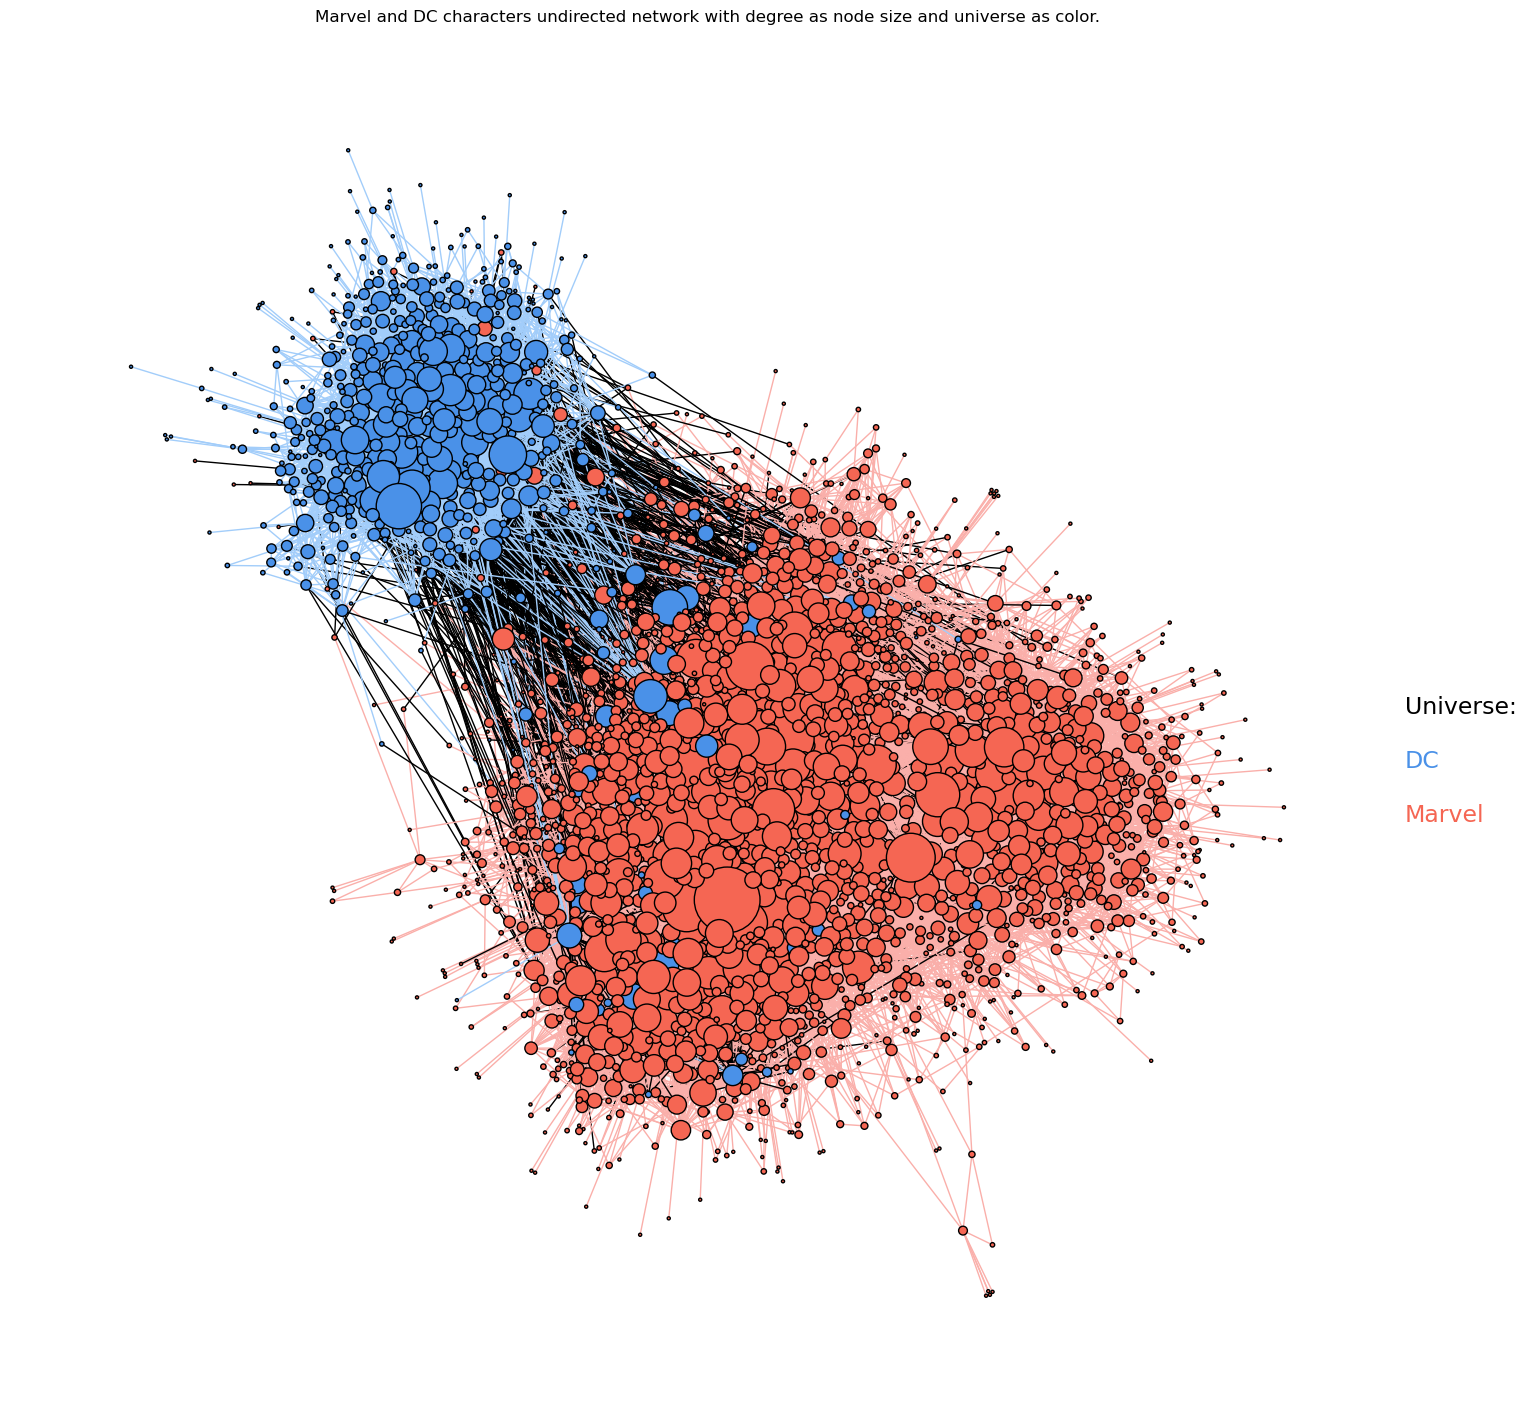

In [22]:
# Since the node size depends on the degree of the node, we need to calculate these degrees
degree_dist = np.array([deg for node, deg in G_undirected.degree()])

node_options = {
    'node_color': color_map_nodes,
    'node_size' : [deg*5  for deg in degree_dist], # node size based on degree,
    'alpha': 1,
}

iterations = 2000
fig = plt.figure(figsize=(18,18))
pos = forceatlas2.forceatlas2_networkx_layout(G_undirected, pos=None, iterations=iterations)
nodes = nx.draw_networkx_nodes(G_undirected, pos=pos, **node_options)
nodes.set_edgecolor('k')
nx.draw_networkx_edges(G_undirected, pos=pos,  edge_color=color_map_edges)

# Kind of legend
start_point = 0.5
plt.figtext(0.9, start_point, 'Universe:', size = 17, color = 'black')
node_col = ['#4a91e8','#f56653']
node_universe = ['DC', 'Marvel']
start_point -= 0.03
for i in range(len(node_universe)):
    plt.figtext(0.9, start_point, str(node_universe[i]), size = 17, color = node_col[i])
    start_point -= 0.03

plt.title('Marvel and DC characters undirected network with degree as node size and universe as color.')
plt.axis('off')

plt.show()

<a id='2.'></a>
# Part 2: Communities 

Quoting [Hypothesis 2, Chapter 9, Network Science](http://networksciencebook.com/chapter/9#basics), a community is a locally dense subgraph in a network.  

In this section, we find for each universe the largest communities, using the Louvain algorithm [1](https://en.wikipedia.org/wiki/Louvain_method), [2](https://sites.google.com/site/findcommunities/). This is achieved by importing the library [`python-louvain`](https://perso.crans.org/aynaud/communities/), is imported as `community`. The communities are subsequently visualized and basic information regarding their size and their [modularity](http://networksciencebook.com/chapter/9#modularity) as quality metric is presented.  

Finally, for the 10 largest  communities, their text is processed and a TF-IDF vector for each community is created. A wordcloud visualization is then shown for the processed text of each community.

__Question__:  
> Identify the communities in one or both of the superhero universes (DC/Marvel).   

> Write a paragraph about your work to identify the communities. The paragraph should include
>   - Information about the algorithm you used to find communities.
>   - The value of modularity for your network.
>   - The number of communities and their sizes (in terms of number of nodes).

__Answer__:  

To recognise the communities for the respective universe, the __Louvain__ method is used. This method is based on the [modularity](http://networksciencebook.com/chapter/9#modularity) metric, which is presented first.  

_Modularity_  
Considering a network with $N$ nodes and $L$ edges and a partition into $n_c$ communities, with each community consisting of $N_{c}$ nodes adn $L_{c}$ edges, $c=1\dots n_c$. In order to assess whether the community structure of this partition, ie. whether the sungraphs created by this partition are real communities based on local density, the modularity metric is used. It is calculated as:
$$
M=\sum_{c=1}^{n_c} \left( \frac{L_{c}}{L} - \left( \frac{k_c}{2L} \right)^{2} \right)
$$  
where $k_c$ is the total degree of the nodes in community $c$.
Modularity can have maximum value of 1 and can also have negative values. The higher the modularity, the better the partition in forming communities. If $M=0$, then the connectivity in the subgraphs is random, while if $M<0$, then the nodes in the subgraphs do not form communities.  

_Louvain algorithm_  
The Louvain algorithm is used to find partitions that potentially form communities in a network. This an unsupervised algorithm, based on maximizing the modularity of the partitions it generates. It is a greedy method with time complexity $\mathcal{O}(n\cdot logn)$. The algorithm has two phases:  
  -  _Phase 1_: Initially each node is assigned to a community of its own. The modularity is computed for this partition. Then a node $i$ is removed from its community and moved to the community of a neighboring node $j$. The change in modularity is computed. This happens for all nodes $i$ and each of its (connected to $i$) $j$ neighbors. The change of node $i$ to the community of $j$ taht is kept is the one that maximizes the increase in modularity. If the change in modularity is negative or zero, node $i$ remains in its starting community.  
  - _Phase 2_: Afterwards, all the nodes in each community are grouped. A network is built where each node represents a community from Phase 1. All internal connections of each community-node of the new network is represented by self loops. After cerating this netowork, Phase 1 is repeated on it.

#### Identifying communities in the DC universe  
First the required library `python-louvain` is imported

In [49]:
!pip install python-louvain
import community

print(community.__version__)

0.15


Afterwards, the network that contains characters from the DC universe is generated as a subgraph of the directed network of all superheroes. 

In [50]:
# List of DC characters
dc_characters = [node[0] for node in G.nodes(data=True) if node[1]['universe'].lower()=='dc']

# Create a directed subgraph of the DC characters
G_dc = G.subgraph(dc_characters)

print(f"The DC universe consists of {len(list(G_dc.nodes))} nodes.")

The DC universe consists of 563 nodes.


Now, the Louvain algorithm is applied on the DC characters subgraph, after it has been transformed to an undirected graph (as per [Week 7](https://github.com/SocialComplexityLab/socialgraphs2022/blob/main/lectures/Week7.ipynb)) and the [documentation](https://perso.crans.org/aynaud/communities/api.html#community.best_partition). The function `best_partition` is used to identify the partition with maximal modularity. 

In [53]:
# Compute the best partition
partition_dc = community.best_partition(G_dc.to_undirected())

# Number of communities found in the dc network
nc_dc = len(set(list(partition_dc.values())))
print(f"Found {nc_dc} different communities for the DC network.")

# Find the modularity of the best partition found in the subgraph.
modularity_best_dc = community.modularity(partition_dc, G_dc.to_undirected())
print(f"The modularity for the best partition of the DC subgraph is: {np.round(modularity_best_dc,3)}")

Found 25 different communities for the DC network.
The modularity for the best partition of the DC subgraph is: 0.305


The Louvain algorithm introduces some randomness and, as a result, the partitions are not always bound to be identical every time the algorithm is executed. At the time of running and writing the report 24 communities were found for the DC universe, with partition modularity $\sim 0.295$. Since the modularity is $>0$, then the communities created by this partition matches two distinct communites. These characters could potentially form a real community in the comics series.

The number of nodes for the mebers of each community can be calculated from the code in the following cell:

In [54]:
for i in range(len(set(partition_dc.values()))):
    # Count the characters in each community 
    n_i = list(partition_dc.values()).count(i)
    print(f"Community {i+1}: {n_i} characters.")

Community 1: 1 characters.
Community 2: 74 characters.
Community 3: 83 characters.
Community 4: 56 characters.
Community 5: 88 characters.
Community 6: 96 characters.
Community 7: 71 characters.
Community 8: 1 characters.
Community 9: 34 characters.
Community 10: 15 characters.
Community 11: 1 characters.
Community 12: 28 characters.
Community 13: 1 characters.
Community 14: 1 characters.
Community 15: 2 characters.
Community 16: 2 characters.
Community 17: 1 characters.
Community 18: 1 characters.
Community 19: 1 characters.
Community 20: 1 characters.
Community 21: 1 characters.
Community 22: 1 characters.
Community 23: 1 characters.
Community 24: 1 characters.
Community 25: 1 characters.


It can be seen that there are many communities that consist of only 1 character. However, these will be removed in the following section. The visualization includes these 1-member communities. The `ForceAtlas2` library is used again. As a note, the node color is determined by the community it is in. This is also the case for the node size. Since we have not sorted the partition based on the size of the community, the node size does not represent anything but another way to see the different communities. There are 24 communities, so adding a colorbar would clutter the visualisation. (_Note_: the number 24 is 'hardcoded'. The algorithm adds randomness, so the number of communities is not guaranteed to be the same for every run!)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 55.75it/s]


BarnesHut Approximation  took  3.90  seconds
Repulsion forces  took  30.52  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.20  seconds
AdjustSpeedAndApplyForces step  took  0.51  seconds


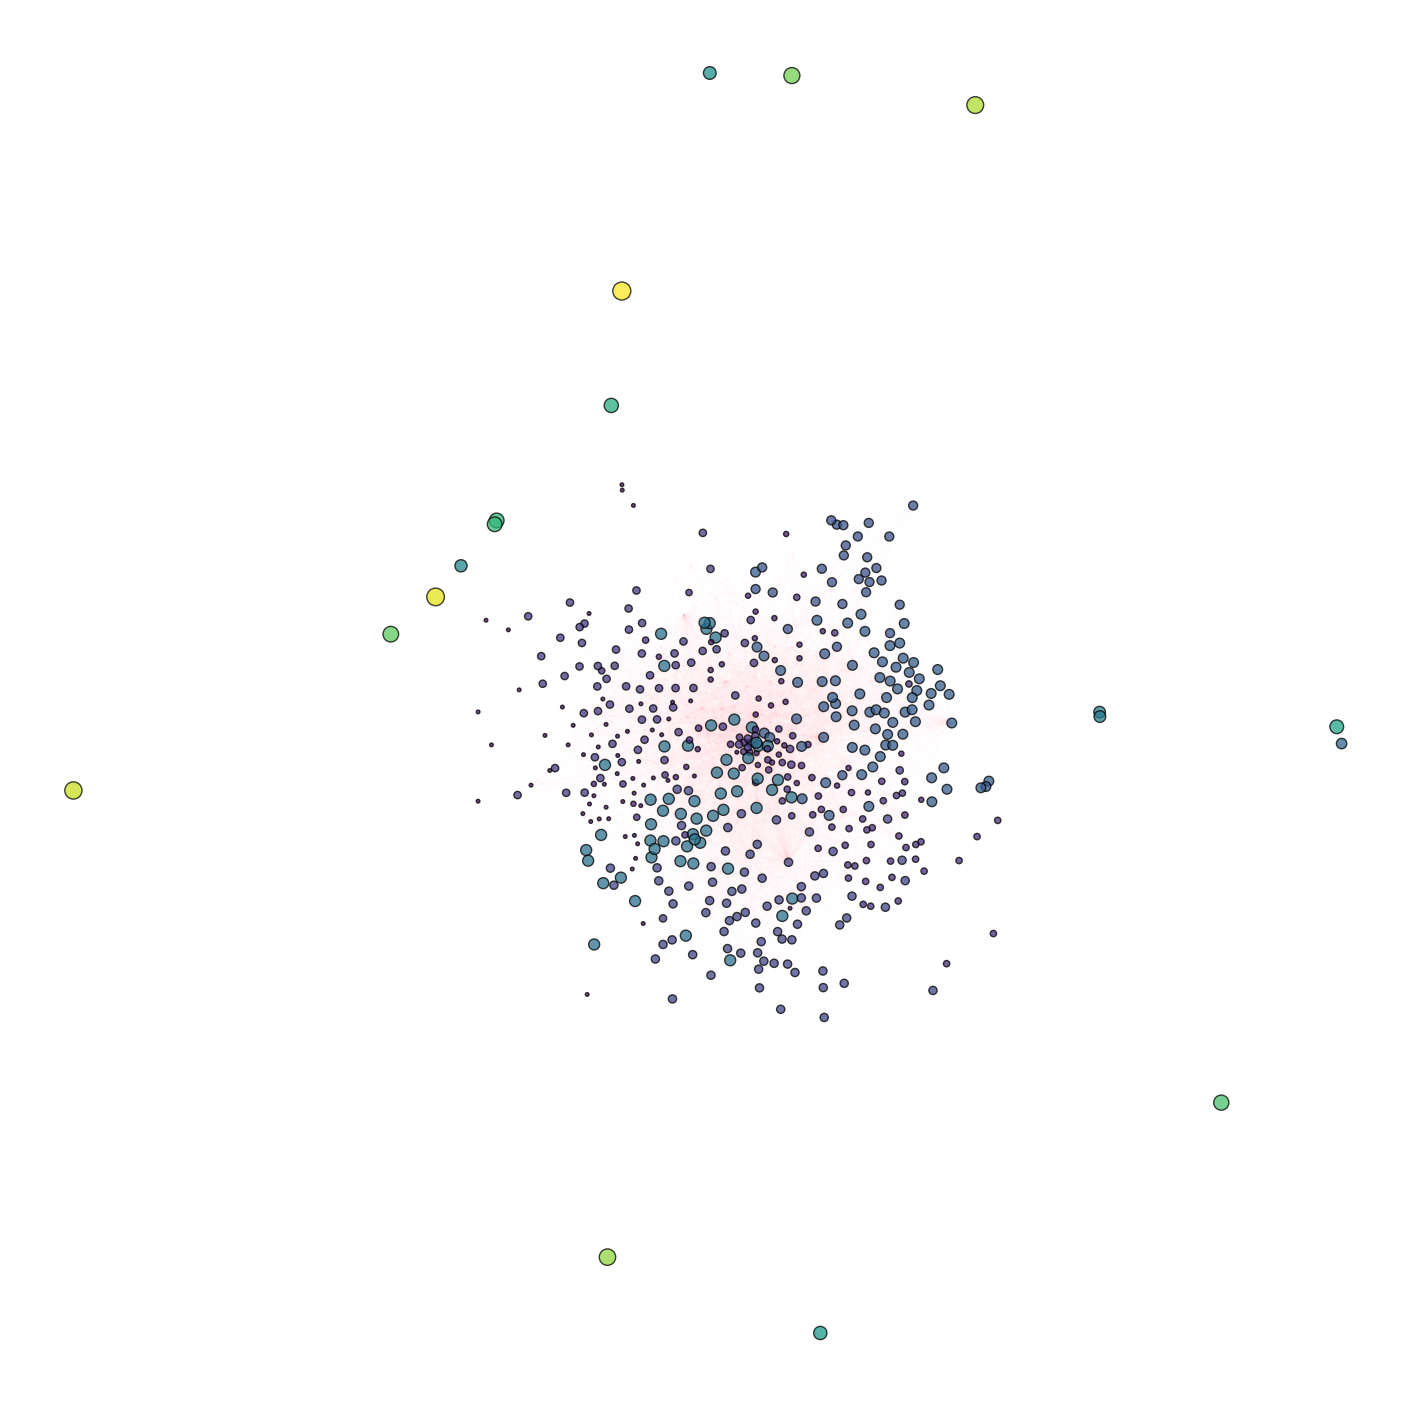

In [27]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=30.0,
                        strongGravityMode=False,
                        gravity=220.0,

                        # Log
                        verbose=True
                        )


options_node = {
    'node_size':np.array(list(partition_dc.values()))*7,
    'node_color': list(partition_dc.values()),
    'alpha':0.75,
}

options_edge = {
    'edge_color': 'pink',
    'alpha': 0.0185,
}


iterations = 2000
fig = plt.figure(figsize=(18,18))
positions = forceatlas2.forceatlas2_networkx_layout(G_dc.to_undirected(), pos=None, iterations=iterations)
nodes = nx.draw_networkx_nodes(G_dc.to_undirected(), positions, **options_node)
nodes.set_edgecolor('k')
nx.draw_networkx_edges(G_dc.to_undirected(), positions, **options_edge)
plt.axis('off')
plt.show()

__Question__:  
> For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

__Answer__:  
The [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) statistic is used to infer how much information a term in a document conveys. It is the product of two terms:  
- The Term frequency (TF): It is the relative frequency of term t within document d.  
  $$
  tf(t,d) = \frac{f_{t,d}}{\sum_{t'\in d}f_{t',d}}
  $$
- The Inverse document frequency (IDF): Factor that diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.  It is a measure of how much information a word provides and takes into consideration all the documents. It is the logarithm scaled inverse fraction of the documents that contain the word. For a set of $D$ documents:
  $$
  idf(t,D) = log \frac{N}{|\{ d \in D: t \in d \}|+1}
  $$

It was previously seen that out of the 24 communities in te DC universe, only 10 had more than 1 members. We want to get the top 10 communities in terms of members size. This is performed in the following cell: 

In [55]:
# Create a dictionary that holds the characters that belong to each community. (Aggregates the partitions_dc values())
dc_communities_chars = {i:[char for (char, comm) in partition_dc.items() if comm==i] for i in set(partition_dc.values())}

# Check if there are more than 10 communities. A good idea might also be to sort them in descending order based
# on the size of the community
dc_communities_chars = dict(sorted(dc_communities_chars.items(), key=lambda x:len(x[1]), reverse=True))


if len(dc_communities_chars.keys())>10:
    print('More than 10 communities found. Keeping the 10 largest ones.')
    dc_communities_chars_tmp = {}
    dict_items = dc_communities_chars.items()
    for comm, chars in list(dict_items)[:10]:
        dc_communities_chars_tmp[comm] = chars
    dc_communities_chars = copy.deepcopy(dc_communities_chars_tmp)
    del dc_communities_chars_tmp
    
for comm, chars_list in dc_communities_chars.items():
    print(f"Community {comm}: {len(chars_list)} members.")

More than 10 communities found. Keeping the 10 largest ones.
Community 5: 96 members.
Community 4: 88 members.
Community 2: 83 members.
Community 1: 74 members.
Community 6: 71 members.
Community 3: 56 members.
Community 8: 34 members.
Community 11: 28 members.
Community 9: 15 members.
Community 14: 2 members.


Now that we have the characters for each community in the top 10, we need to process their wikitext. A document consists of the wikitext of each caharacter in a community, integrated in a large string object. These documents can be stored in a dictionary with the keys being the community number. 

In [56]:
# Library used to load the universes dataframes from the database
!pip install psycopg2
import psycopg2

In [57]:
# Data frame of the DC characters and their associated wikitext
dc_df = DataImport('DC')

# Since one universe is loaded, import also the other one for future use.
marvel_df = DataImport('Marvel')

In [58]:
dc_communities_texts = {}

for comm in tqdm(list(dc_communities_chars.keys())):
    doc = ""
    for char in dc_communities_chars[comm]:
        try:
            doc += dc_df.loc[dc_df['character_name']==char].values[0,1]
        except AttributeError as e:
            print(e)
            print(f"{char} has no wiki-text.")
    dc_communities_texts[comm] = doc

  0%|          | 0/10 [00:00<?, ?it/s]

Due to parsing of the wikitext, it can happen with some corner cases that one or more characters end up with no text. This can also be the case for some communities with a few members, that consist of characters like the aforementioned. As a result, it is better to find and remove communities with no text. This is the focus of the following cell:

In [59]:
communities_with_zero_text = []
for comm in list(dc_communities_texts.keys()):
    if len(dc_communities_texts[comm])==0:
        print(f"Community {comm} has zero text associated with it.")
        communities_with_zero_text.append(comm)

Community 14 has zero text associated with it.


In [60]:
for comm in communities_with_zero_text:
    try:
        del dc_communities_texts[comm]
    except KeyError as e:
        print(e)
        print(f"Community {comm} has already been deleted from the text dictionary")
    try: 
        del dc_communities_chars[comm]
    except KeyError as e:
        print(e)
        print(f"Community {comm} has already been deleted from the characters dictionary")

Now that we have the documents for each community in the DC universe, we can use `nltk` to tokenize each document.

In [61]:
!pip install nltk
import nltk

In [62]:
# Use only words and not punctuation as tokens.
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') # Initialize a regec tokenizer from nltk

# Use the tokenizer object to tokenize the documents
tokenized_docs_dict_dc = {i: tokenizer.tokenize(dc_communities_texts[i]) for i in list(dc_communities_texts.keys()) }

Now that for each community we have the tokenized text, the TF can be computed. The following function computes the TF:

In [63]:
def compute_tf(tokens_array):
    '''
    Computes the Term Frequency (TF) for a tokenized document.
    
    Input:
        tokens_array: list of tokens.
    Output:
        Sorted dictionary with tokens as keys and TF as values.
    '''
    tf_dict={}
    word_count_dict = dict(nltk.FreqDist(tokens_array))
    doc_len = len(tokens_array)
    for token, counts in word_count_dict.items():
        tf_dict[token] = counts/doc_len
    return dict(sorted(tf_dict.items(), key=lambda x: x[1], reverse=True))

Use the `compute_tf` function to calculate the TF for every community:

In [64]:
tf_dict = { i: compute_tf(tokenized_docs_dict_dc[i]) for i in dc_communities_chars.keys()}

The following function calculates the IDF for the terms in a list of tokenized documents. All the documents for the __DC__ communities are included.

In [65]:
def compute_idf(tokenized_documents_dict):
    '''
    Computes the Inverse Document Frequency (IDF) of a collection of documents.
    
    Inputs:
        tokenized_documents_dict: dict. Keys are the document identifier, eg. title, number, etc.
                                        Values are lists of tokens for each document
    Outputs:
        idf_dict: dict. Keys are tokens. Values are IDF values.
    '''
    N = len(tokenized_documents_dict)
    idf_dict = {}
    for doc in tqdm(tokenized_documents_dict.values()):
        words = list(nltk.FreqDist(doc))
        for word in words:
            idf_dict[word] = idf_dict.get(word, 0) + 1
    
    for word in list(idf_dict.keys()):
        idf_dict[word] = np.log(N/(idf_dict[word]))
    return idf_dict

In [66]:
idf_dict_dc = compute_idf(tokenized_docs_dict_dc)

  0%|          | 0/9 [00:00<?, ?it/s]

To calculate the TF-IDF, the TF terms for each community are multiplied by the IDF terms for created from the documents of all the communities, here for the DC universe. A function that calculates the TF-IDF for a community is declared in the following cell:

In [67]:
def compute_tf_idf(tokens, idf_dictionary, number_of_docs):
    tf_dict = compute_tf(tokens)
    tf_idf_dict = {}
    for token, tf in tf_dict.items():
        tf_idf_dict[token] = tf*idf_dictionary.get(token,np.log(number_of_docs))
    return dict(sorted(tf_idf_dict.items(), key=lambda x: x[1], reverse=True))

In [68]:
tf_idf_dc = { i: compute_tf_idf(tokenized_docs_dict_dc[i], idf_dict_dc, len(tokenized_docs_dict_dc)) for i in dc_communities_chars.keys()}

__Question__:  
> Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

__Answer__:  

We can visualize the TF-IDF vector for each community inside the DC universe. This is possible by using the [`wordcloud` ](https://github.com/amueller/word_cloud) library.

In [69]:
from wordcloud import WordCloud

0it [00:00, ?it/s]

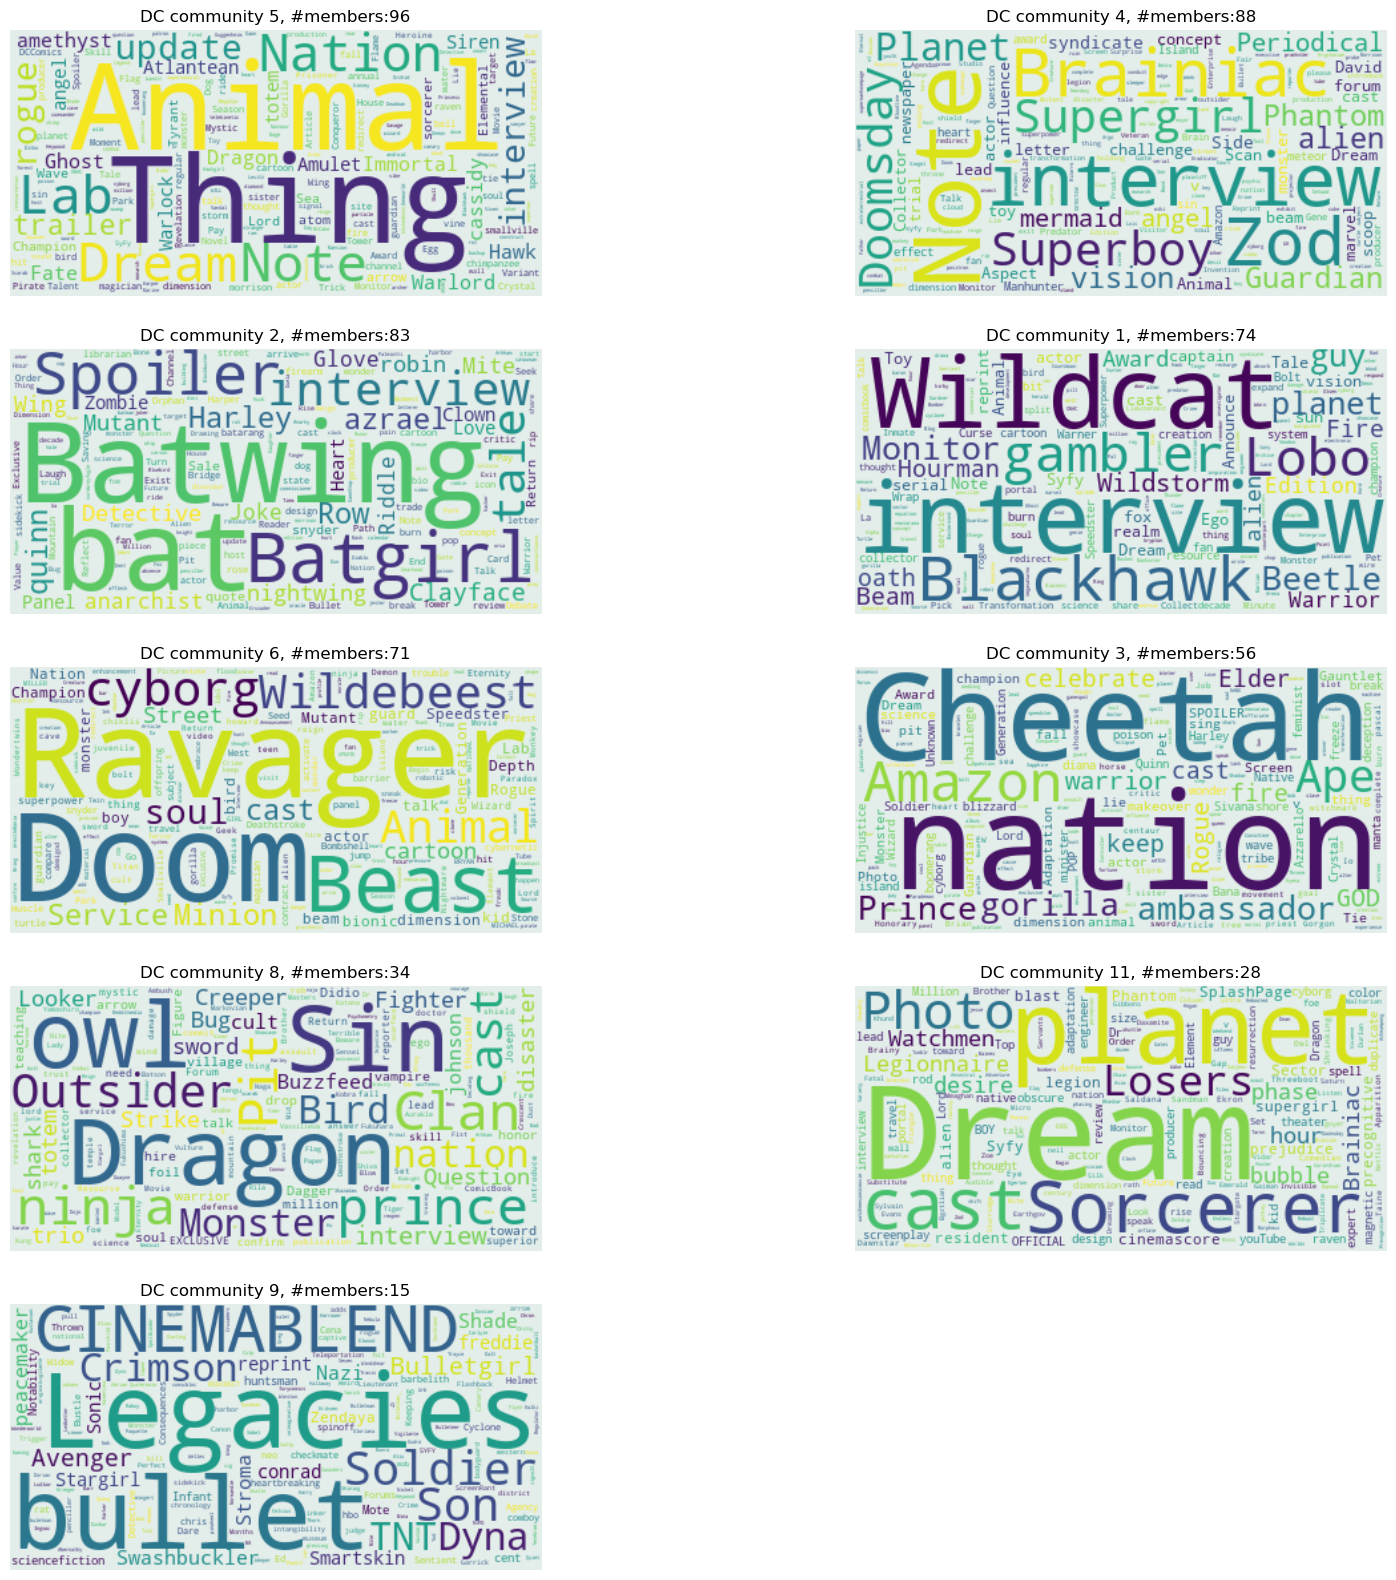

In [75]:
# Generate a word cloud image for each community

n = len(dc_communities_chars)
top_n = 25
fig= plt.figure(figsize=(20,20))

color = (227,237,233)

for j,i in tqdm(enumerate(dc_communities_chars.keys())):
    plt.subplot(np.ceil(n/2).astype(int), 2, j+1)
    terms = [ token for (token, counts) in tf_idf_dc[i].items() if counts> 0 ][:-1]
    wordcloud = WordCloud(background_color=color ,collocations=False).generate(' '.join(terms))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'DC community {i}, #members:{len(dc_communities_chars[i])}')
    plt.axis("off")

plt.show()

The wordclouds for the communities appear to show the most prominent information for each community. The most important is that this has been achieved without removing any stopwords by using `nltk`, or by manually removing terms that are very frequent, such as wikipages terms. For many of these wordclouds, especially those with many members, character naems can also be seen. As a result, using the TF-IDF results in more representative worldclouds and more importantly, more representative text for each community.

<a id='3.'></a>
# Part 3: Sentiment 

__Question__:  
> First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment. Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.

__Answer__:  
In order to calculate the sentiment of the words for each character, a file that contains relevant information must be loaded. In this case, we will be using the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#s1). This dataset was created as:  

1. 4 disparate sources for text were used:  
  - Twitter  
  - Google books (English)
  - Music lyrics (1960-2007)  
  - New York Times (1987-2007)  
2. For each corpus, the word list frequency, with decreasing frequency of occurrence, was compiled.  Because only word frequency is used, the following is achieved:  
  - Precision  
  - Relevance  
  - Impartiality
3. The top 5000 words from each source were merged, resulting in $\sim 10222$ words.  
4. MechanicalTurk was used to evaluate how each word make the user feel on a scale of 9 point integer scale. 50 evaluations per word. For each evaluation, around 100 randomly chosen words at a time.  
5. Stemming words was avoided.
6. The average evaluation for each word was calculated.

In [76]:
# Import LabMT
LabMT_list = pd.read_csv('Data_Set_S1.txt', sep='\t', header=2)

In order to calculate the sentiment for a character, its text needs to be tokenized. No stopwords are removed.  Then, each word is looked up from the `LabMT.txt` file and its sentiment is added in a list. Finally, the mean of this sentiments list is calculated and returned as the chaarcter's page sentiment. The way the sentimentis calculated for each word is also described in [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#s1). The following functions are defined to make the sentiment calculations:

In [77]:
def get_sentiment(token_frequency_tuple, sentiments_df):
    '''
    Calculate token's (average) sentiment from the sentiments pandas dataframe
    The data frame should have a 'word' column and a 'happiness_average' column!
    
    Inputs:
        token_frequency_tuple: tuple of (word, word frequency)
        sentiments_df: pandas dataframe that contains the word and its average sentiment.
    Outputs:
        weighted_level_happiness: float 
    '''
        
    word, f_i = token_frequency_tuple    
    
    if word not in list(sentiments_df['word']):
        return -1 # Return , since only positive values will be used in the final calculation. 
    
    try:
        h_i = sentiments_df.loc[sentiments_df['word'] == word]['happiness_average'].to_numpy()[0]
    except Exception as e:
        print(e)
        return 0        
    
    weighted_level_happiness = (f_i*h_i)/f_i # from the linked paper
    
    return weighted_level_happiness

In [78]:
def sentiment_from_tokens(tokens_list, word_sentiments_df):
    '''
     Calculates sentiment given a list of tokens, using the word list from Data_Set_S1.txt file.
     Acquired from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752
     Implements Equation 1 from the referred journal paper.
     
     Inputs:
         tokens_list: array of strings. The tokenized text we want to calculate the sentiment of.
                                        It should be lowercase, but it is also repeated here.
         
        word_sentiments_df: Pandas DataFrame of words and their average happiness rating from each of the 4 sources.
                                            It could be global, but it is good practice avoid those.
        
     Outputs:
         sentiment: double  The sentiment of the tokenized text it was passed, according to equation 1.
         
    '''
    
    # According to Equation 1, we need the frequency the tokens appear in the text, or the list of tokens
    token_freq = dict(nltk.FreqDist(tokens_list))
    
    # Calculate sentiment of each token
    indiv_token_sentiments = np.array([ get_sentiment(indiv_token_freq, word_sentiments_df) for indiv_token_freq in token_freq.items() ])
    
    # Remove the values less or equal to 0 from the mean calculation
    idx = np.where(indiv_token_sentiments>0)[0]
    
    # If nothing is left in individual sentiments array, return 0
    if len(idx)==0:
        return 0
    
    # Return the mean of the sentiments array
    sentiment = indiv_token_sentiments[idx].mean() # Not directly returned for debugging purposes
    
    return sentiment

Now, we will use the function `sentiment_from_tokens` to iterate over each character's wikitext. Each character's sentiment will be stored as value in a dictionary.

In [79]:
try:
    with open('sentiment_dict.pickle', 'rb') as f:
        sentiment_dict = pickle.load(f)
except FileNotFoundError as e:
    print(e)
    print('Generating sentiment dictionary.')
    
    # Create a tokenizer object
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    sentiment_dict = {}


    for df in [dc_df, marvel_df]:
        for char in tqdm(df['character_name'].tolist()):
            tokens = tokenizer.tokenize(df.loc[df['character_name']==char].values[0,1])

            # Calculate sentiment of tokens
            sentiment = sentiment_from_tokens(tokens, LabMT_list)
            sentiment_dict[char] = sentiment
            
    with open('sentiment_dict.pickle', 'wb') as f:
        pickle.dump(sentiment_dict, f)

We can also set the sentiment as an attribute for the network.

In [80]:
nx.set_node_attributes(Gcc, sentiment_dict, 'sentiment')

Now that we have the average sentiment for each character, the distribution of the sentiment over all characters can be plotted. However, there might be some characters that have no sentiment value. This can happen due to them not having wikitext (faulty parsing) or the words in their wikitext might not be present in the `LabMT` data frame. So, initially, only the characters with positive values of sentiment are kept:

In [81]:
# Keep nodes with sentiment larger than 0
nodes_with_sent_l_zero =  [node[0] for node in Gcc.nodes(data=True) if node[1]['sentiment']>0 ]

# Get only positive sentiment values
sentiments_list = [ node[1]['sentiment'] for node in Gcc.nodes(data=True) if node[1]['sentiment']>0 ]

Some basic statistics can be calculated by using the following function:

In [82]:
def get_basic_statistics(sentiment_values, x_percentile = 10, y_percentile = 90):
    '''
    Returns a tuple of the following stats:
    ( mean, median, x'th percentile, y'th percentile )
    '''
    
    vals = np.asarray(sentiment_values)
    
    mean_ = vals.mean()
    median_ = np.median(vals)
    x_th_percentile = np.percentile(vals, x_percentile)
    y_th_percentile = np.percentile(vals, y_percentile)

    return mean_, median_, x_th_percentile, y_th_percentile

In [83]:
def print_basic_stats(stats_tuple, rounding=3):
    '''
    Helper function that prints the basic stats results
    from the output of 'get_basic_statistics' function.
    '''
    
    assert len(stats_tuple) == 4
    print(f"Mean: {np.round(stats_tuple[0], rounding)}")
    print(f"Median: {np.round(stats_tuple[1], rounding)}")
    print(f"10'th percentile: {np.round(stats_tuple[2], rounding)}")
    print(f"90'th percentile: {np.round(stats_tuple[3], rounding)}")

In [84]:
mean_sent, median_sent, tenth_th_percentile, ninetyth_percentile = get_basic_statistics(sentiments_list)
print_basic_stats(get_basic_statistics(sentiments_list), rounding=3)

Mean: 5.444
Median: 5.444
10'th percentile: 5.318
90'th percentile: 5.55


The sentiment histogram is plotted:

In [85]:
# Binning
v = np.arange(min(sentiments_list), max(sentiments_list)+0.1, 0.1)

# Get edges and counts
hist, edges = np.histogram(sentiments_list, bins=v)

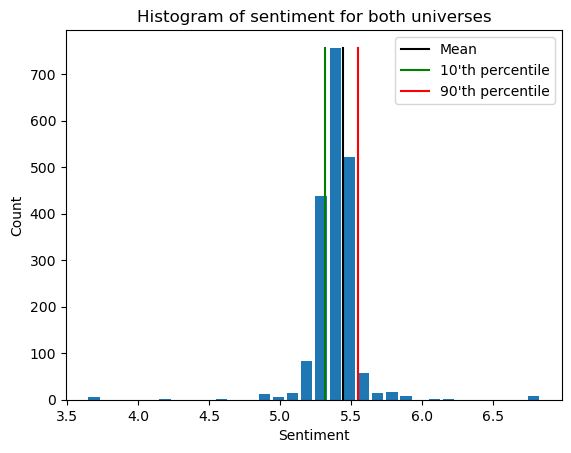

In [88]:
fig = plt.figure()
plt.bar(edges[:-1], hist, width=0.08)
plt.plot([mean_sent, mean_sent],[min(hist), max(hist)], 'k-', label='Mean')
plt.plot([tenth_th_percentile, tenth_th_percentile],[min(hist), max(hist)], 'g-', label="10'th percentile")
plt.plot([ninetyth_percentile, ninetyth_percentile],[min(hist), max(hist)], 'r-', label="90'th percentile")
plt.title('Histogram of sentiment for both universes')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.legend()
plt.show()

__Question__:  
> Now grab the good/bad character names ([from this file](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2022/b1668fe5fbea0765ed6f9cf896bfaf208a13765b/files/wiki_meta_data.csv), see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.

__Answer__:  
First, the contents of the link are copied to the file `metadata.csv`. This file is loaded in the `metadata_df` object:

In [90]:
metadata_df = pd.read_csv('metadata.csv',sep=',' ,header=0, index_col=0)

In [91]:
metadata_df.head(10) # Quick overview of how the loaded csv looks as pandas dataframe

,CharacterName,WikiLink,universe,woman,man,good,bad
0,Abomination,Abomination (character),Marvel,0,1,0,1
1,Absorbing Man,Absorbing Man,Marvel,0,1,0,1
2,Achebe,Achebe (comics),Marvel,0,0,0,0
3,Agent,Agent (comics),Marvel,0,1,1,0
4,Agent X,Agent X (Marvel Comics),Marvel,0,1,1,0
5,Airstrike,Dmitri Bukharin,Marvel,0,0,0,0
6,Air-Walker,Air-Walker,Marvel,0,1,0,1
7,Liz Allan,Liz Allan,Marvel,0,0,0,0
8,Amatsu-Mikaboshi,Amatsu-Mikaboshi (comics),Marvel,0,0,0,0
9,American Dream,American Dream (comics),Marvel,0,0,0,0


Now, separate the good from the bad characters, as indicated by the corresponding columns of the `metadata_df` object. A cgaracter is labeled as _bad_ if the value of its `bad` column is equal to 1. Otherwise this character is ignored and not added in the _bad_ characters dataframe. This is also the case for the _good_ characters.

In [92]:
good_chars = metadata_df.loc[metadata_df['good']==1]
bad_chars = metadata_df.loc[metadata_df['bad']==1]

Now, we get the sentiment for each character in the bad and good dataframe, and store these in a dictionary, with the character's name as key and the sentiment as value:

In [93]:
good_sentiment = {node[0]:node[1]['sentiment'] for node in Gcc.nodes(data=True) if node[1]['sentiment']>0 and node[0] in good_chars['CharacterName'].to_list()}
bad_sentiment = {node[0]:node[1]['sentiment'] for node in Gcc.nodes(data=True) if node[1]['sentiment']>0 and node[0] in bad_chars['CharacterName'].to_list()}

For the good and bad characters, the basic statistics are calculated as:

In [94]:
good_stats = get_basic_statistics(np.array( list(good_sentiment.values()) ))
bad_stats = get_basic_statistics(np.array( list(bad_sentiment.values()) ))

print(f"Good characters' sentiment:\n")
print_basic_stats(good_stats)

print()

print(f"Bad characters' sentiment:\n")
print_basic_stats(bad_stats)

Good characters' sentiment:

Mean: 5.475
Median: 5.473
10'th percentile: 5.383
90'th percentile: 5.558

Bad characters' sentiment:

Mean: 5.41
Median: 5.406
10'th percentile: 5.302
90'th percentile: 5.515


From eyballing the basic statistics of the good and bad characters, it does not seem easy to separate characters based on sentiment. The calculated sentiment values using the `LabMT` dataframe are pretty similar. This is also visible in the following histograms for the two character groups:

In [95]:
# Step for binning the continuous variable sentiment
step = 0.001

# Create the bins for good/bad characters
v_good = np.arange(min(good_sentiment.values()), max(good_sentiment.values())+3*step, step)
v_bad = np.arange(min(bad_sentiment.values()), max(bad_sentiment.values())+3*step, step)

# Calculate the edges and counts of each bin, for good/bad characters
hist_good, edges_good = np.histogram( np.array( list(good_sentiment.values()) ), bins=v_good )
hist_bad, edges_bad = np.histogram( np.array( list(bad_sentiment.values()) ), bins = v_bad )

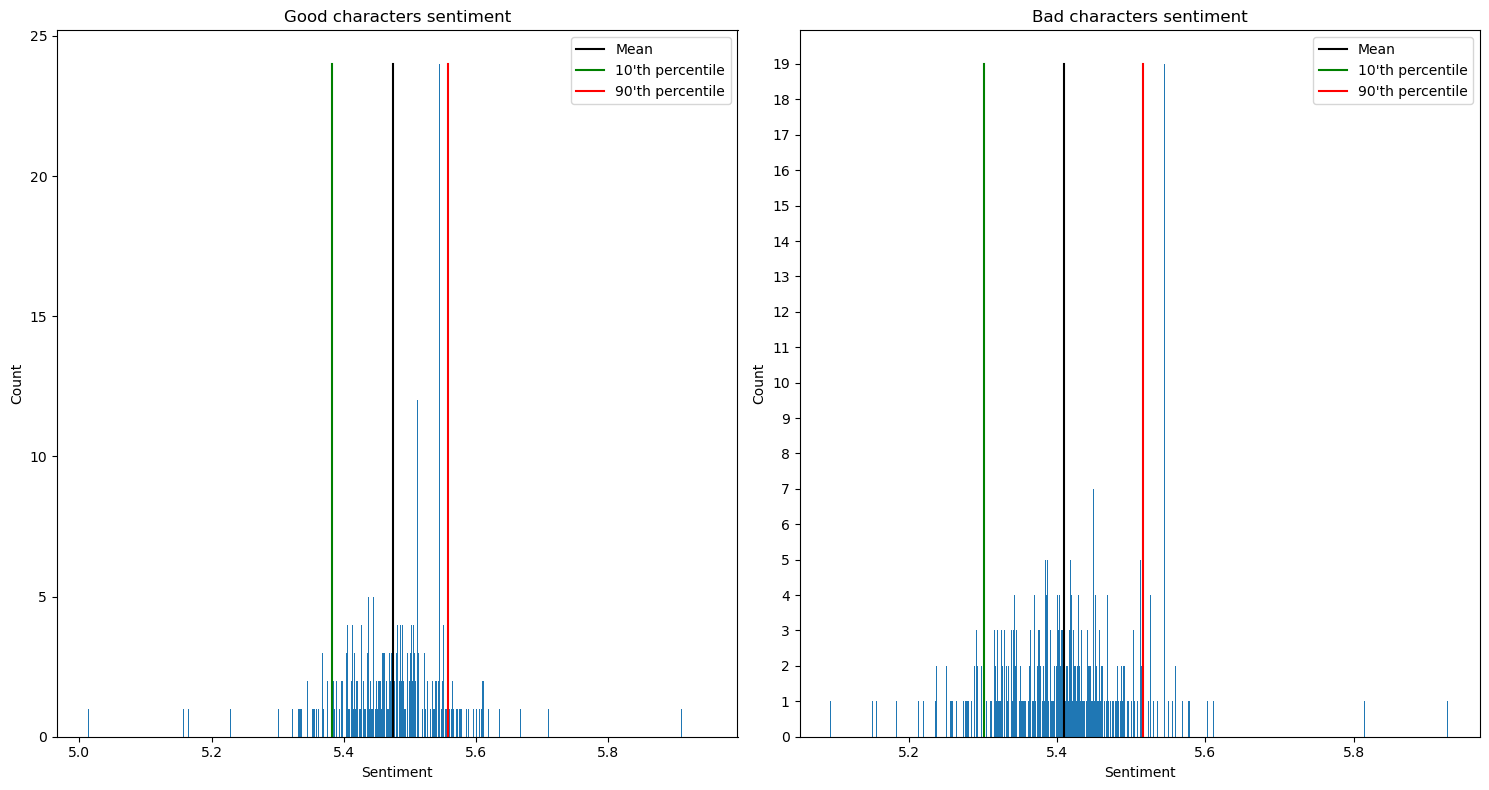

In [97]:
fig = plt.figure(figsize=(15,8))

# Good characters sentiment histogram
plt.subplot(1,2,1)
plt.bar(edges_good[:-1], hist_good, width=step)

# Plot the statistics
mean_, median_, tenth_p, ninet_p = good_stats # Get basic stats for good characters
plt.plot([mean_, mean_],[min(hist_good), max(hist_good)], 'k-', label='Mean')
plt.plot([tenth_p, tenth_p],[min(hist_good), max(hist_good)], 'g-', label="10'th percentile")
plt.plot([ninet_p, ninet_p],[min(hist_good), max(hist_good)], 'r-', label="90'th percentile")

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Good characters sentiment')
plt.legend()

# Bad characters sentiment histogram
plt.subplot(1,2,2)
plt.bar(edges_bad[:-1], hist_bad, width=step)

mean_, median_, tenth_p, ninet_p = bad_stats # Get basic stats for bad characters
plt.plot([mean_, mean_],[min(hist_bad), max(hist_bad)], 'k-', label='Mean')
plt.plot([tenth_p, tenth_p],[min(hist_bad), max(hist_bad)], 'g-', label="10'th percentile")
plt.plot([ninet_p, ninet_p],[min(hist_bad), max(hist_bad)], 'r-', label="90'th percentile")

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.yticks(np.arange(min(hist_bad), max(hist_bad)+1,1).astype(int)) # Enforce integers for the y-label
plt.title('Bad characters sentiment')
plt.legend()

plt.tight_layout()
plt.show()

The fact that the statistics regarding the sentiment of good and bad characters are close, could be attributed to keeping words that are neutral in regards to sentiment. It is expected that removing words with sentiment close to the mean, or avoiding calculating the sentiment of stopwords, the sentiment statistics would be more distrinct.

__Question__:  
> Finally use the label permutation test (see Week 5) to investigate the two hypotheses below
> - H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
> - H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.



__Answer__:  
_Label permutation test_: It is desired we test the two hypotheses. One way to do this, is via _simulation_. The ground truth is known beforehand, ie. which characters are good or bad and what their sentiment statistics are. Afterwards, we randomly select a set of characters of size equal to the one of the ground truth case. The same basic statistic of interest is calculated. Then it is compared against the ground truth and the hypothesis is either Tru or False. This test is repeated a number of times, here for a thousand (10000) repetitions.

In [62]:
# Setting the number of repetitions for the test
n_iter = 10000

> - H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.

Here, we want to see out of the 10000 repetitions, for how many of them the average value of the good characters' sentiment is higher than the average sentiment of randomly selected group.

In [63]:
# First, find the length of the good characters list
good_chars_len = len(good_chars)

# Initialize event counter to 0. It is incremented every time the hypothesis holds
n_events = 0
for _ in tqdm(range(n_iter)):
    
    # Random selection without substitution of characters. Same length as the good characters list
    random_good_sentiment = np.random.choice(sentiments_list, good_chars_len, replace=False)
    
    # Check if hypothesis H1 holds. If it does, increment n_events
    if random_good_sentiment.mean() < good_stats[0]:
        n_events += 1

  0%|          | 0/10000 [00:00<?, ?it/s]

In [64]:
print(f"The event that the good characters have higher mean sentiment a randomly selected group holds: {n_events}/{n_iter}")

The event that the good characters have higher mean sentiment a randomly selected group holds: 10000/10000


This hypothesis, $H1$, is valid for every repetition. Now test $H2$: 

> - H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

In [65]:
# Find the length of the bad characters list
bad_chars_len = len(bad_chars)

# Initialize event counter to 0.
n_events = 0
for _ in tqdm(range(n_iter)):  
    
    # Random character selection without substitution
    random_bad_sentiment = np.random.choice(sentiments_list, bad_chars_len, replace=False)
    
    # Check if H2 holds
    if random_bad_sentiment.mean() > bad_stats[0]:
        n_events += 1

  0%|          | 0/10000 [00:00<?, ?it/s]

In [66]:
print(f"The event that the bad guys have lower mean sentiment thatn random characters holds: {n_events}/{n_iter}")

The event that the bad guys have lower mean sentiment thatn random characters holds: 10000/10000


Again, hypothesis $H2$ holds for all repetitions.